---
# Comparison partial FOV pRF with Whole-Brain pRF

This notebook shows the pRF-analysis of the partial FOV acquired while registering the lowres anatomical scan to the session 1 anatomy. The experiment consisted of 1 iteration of the lineprf2 experiment, with 2 bar thicknesses (thin/thick) and 4 motion directions (Left-right, right-left, up-down, down-up); total = 8 bar configurations. 

The goals of the notebook are as follows:
- Create design matrix where stimulus duration (0.25s) < TR (1.1s) - the line experiment will follow a similar strategy
- Implement pRF-analyses as classes
- Compare pRF estimates obtained during linescanning session with pRF+anatomy session

## Registration workflow

go to directory: `cd /data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_prf`

1) Apply the inverse of `from-fs_to_ses?_desc-genaff`-matrix to the functional data; this brings the functional data in FreeSurfer space: `call_antsapplytransforms -i 1 -t lin /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/freesurfer/sub-003/mri/orig.nii.gz sub-003_ses-3_task-pRF_acq-3DEPI_run-1_bold.nii.gz sub-003_ses-3_task-pRF_acq-3DEPI_run-2_bold.nii.gz /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/pycortex/sub-003/transforms/sub-003_from-fs_to-ses3_desc-genaff.mat`

2) Make a FreeSurfer-compatible `.dat`-registration matrix: `call_createident -s sub-003 ident.dat sub-003_ses-3_task-pRF_acq-3DEPI_run-2_bold.nii.gz`

3) Warp to fsnative/fsaverage: `call_vol2fsaverage -r ident.dat -o $PWD -p sub-003_ses-3_task-pRF sub-003 sub-003_ses-3_task-pRF_acq-3DEPI_run-2_bold.nii.gz run-2_bold.func`. This calls `call_stackgiftis` and `call_giftimeta` internally, creating `.gii`-files with the TR in the metadata, and the `.npy`-output like `pybest` would give

In [1]:
from IPython.display import Image
%reload_ext autoreload
%autoreload 2

import numpy as np
from linescanning import utils,glm,prf
from prfpy import timecourse
import matplotlib.pyplot as plt
import os
import warnings
from scipy.io import loadmat
from scipy.ndimage import zoom
from nilearn import signal
from nilearn.glm.first_level.design_matrix import _cosine_drift as dct_set

warnings.simplefilter('ignore')

opj = os.path.join
base = os.environ['DIR_PROJECTS']

base_dir = opj(base, 'hemifield')
fig_dir = opj(base_dir, 'code', 'figures', 'prf')
task_dir = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/sourcedata/sub-003/ses-3/task/sub-003_ses-3_run-1_task-PRF"
func_dir = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_prf"
print(base_dir)


/home/heij/.conda/envs/mpl/lib/python3.10/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/heij/.conda/envs/mpl/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield


### Fetch the onsets of pRF-experiment

In [2]:
# load onsets
onsets = utils.ParseExpToolsFile(utils.get_file_from_substring(".tsv", task_dir), TR=1.111508, delete_vols=0)
trial_df = onsets.get_onset_df()
print(f"TR = {onsets.TR}")
trial_df.tail(20)

TR = 1.111508


,onset,event_type,subject,run
500,175.471935,vertical,1,1
501,175.541486,vertical,1,1
502,175.858221,vertical,1,1
503,176.166634,vertical,1,1
504,176.483204,vertical,1,1
505,176.799868,vertical,1,1
506,177.116627,vertical,1,1
507,177.433194,vertical,1,1
508,177.741504,vertical,1,1
509,178.058231,vertical,1,1


### Fetch the functional data; apply high-pass filter + zscore data

Load data, apply highpass filtering in the form of discrete cosine set

(314134, 200)
(314134, 200)


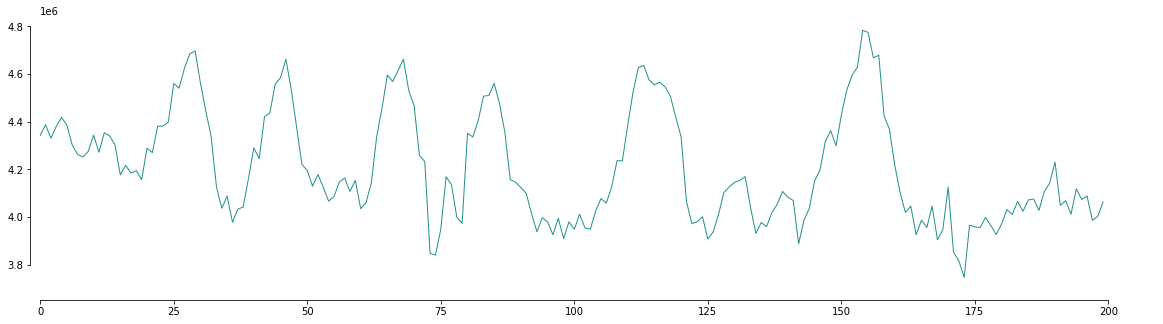

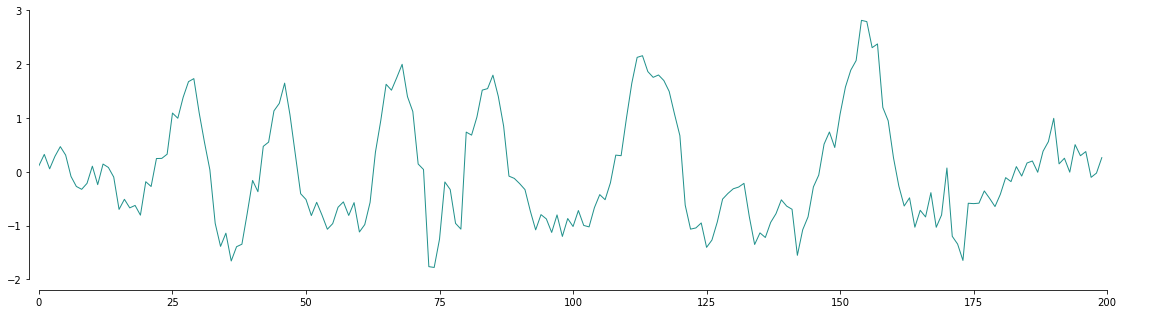

In [6]:
# load functional data
func_data = np.load(utils.get_file_from_substring("sub-003_ses-3_task-pRF_hemi-LR_space-fsnative_run-2_bold.func.npy", func_dir))

print(func_data.shape)

lb=0.01
n_vol = func_data.shape[-1]
st_ref = 0  # offset frametimes by st_ref * tr

# define discrete cosine
ft = np.linspace(st_ref * onsets.TR, (n_vol + st_ref) * onsets.TR, n_vol, endpoint=False)
hp_set = dct_set(lb, ft)
func_cleaned = signal.clean(func_data.T, detrend=False, standardize='zscore', confounds=hp_set).T

print(func_cleaned.shape)

utils.LazyPlot(func_data[336,...], figsize=(20,5), set_xlim_zero=True)
utils.LazyPlot(func_cleaned[336,...], figsize=(20,5), set_xlim_zero=True)

### Create design matrix for partial FOV experiment

Here, I chose to select the image in the middle of a given TR. This is because every TR the bar would move 4-5 places (TR = 1.1s, bar duration = 0.25s). So I loop through the TRs, add 0.5*TR, and find the closest value of that in the onset file of the experiment. You can then load in the appropriate screenshot based on the trial number that's coupled to the onset time.

(270, 270, 200)


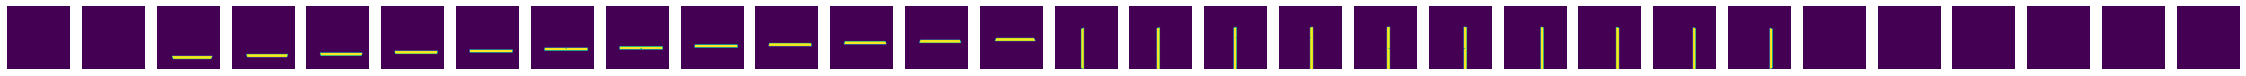

In [4]:
design_matrix = prf.create_line_prf_matrix(task_dir, 
                                           stim_duration=0.25, 
                                           nr_trs=func_data.shape[-1],
                                           n_pix=270,
                                           stim_at_half_TR=True,
                                           deleted_first_timepoints=0,
                                           deleted_last_timepoints=0,
                                           TR=onsets.TR,
                                           skip_first_img=False)

print(design_matrix.shape)

nr_plots = 30
start = 20

f, ss = plt.subplots(1,nr_plots,figsize=(40,7))
# ss[0].imshow(design_matrix['stim'].T[20])

for x in range(start,start+nr_plots):
    ss[x-start].imshow(design_matrix[...,x])
    ss[x-start].axis('off')

I converted most of the pRF-stuff to classes. For this, I needed the repetition time. However, pybest outputs its denoised files in numpy-format, so I had to find another way of getting the TR. fMRIprep stores the TR in the gii-files as metadata. Given that I converted the functional data for this experiment to surface files myself (see `Registration workflow` above), this didn't happen at first. So I wrote some functions that do these operations for me. Below you can see it indeed now has the TR in the gifti metadata

In [7]:
gii_file = utils.get_file_from_substring("sub-003_ses-3_task-pRF_hemi-L_space-fsnative_run-3_bold.func.gii", func_dir)
print(gii_file)
gifti = utils.ParseGiftiFile(gii_file)
gifti.__dict__

/data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_prf/sub-003_ses-3_task-pRF_hemi-L_space-fsnative_run-3_bold.func.gii


{'gifti_file': '/data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_prf/sub-003_ses-3_task-pRF_hemi-L_space-fsnative_run-3_bold.func.gii',
 'f_gif': <nibabel.gifti.gifti.GiftiImage at 0x7f6f0d2bbe50>,
 'data': array([[2690771.2, 2896243.2, 1578017.2, ...,       0. ,       0. ,
               0. ],
        [3120036.8, 3345314.2, 1911971.4, ...,       0. ,       0. ,
               0. ],
        [2900508.8, 3196758.8, 1880346.9, ...,       0. ,       0. ,
               0. ],
        ...,
        [2871641.5, 2796760.5, 2329286.2, ...,       0. ,       0. ,
               0. ],
        [2547122. , 2734521. , 2313736.5, ...,       0. ,       0. ,
               0. ],
        [2709133.2, 2874805.8, 2217690. , ...,       0. ,       0. ,
               0. ]], dtype=float32),
 'set_tr': None,
 'meta': {'TimeStep': '1111.0'},
 'TR_ms': 1111.0,
 'TR_sec': 1.111}

### pRF fitting

Do everything in the pRFmodelFitting class

In [8]:
from linescanning.prf import pRFmodelFitting

fov_prf = opj(func_dir, "sub-003_ses-3_task-pRF_model-gauss_stage-grid_desc-prf_params.npy")
if not os.path.exists(fov_prf):
    modelling = pRFmodelFitting(func_cleaned, 
                                design_matrix=design_matrix, 
                                TR=gifti.TR_sec, 
                                model='gauss', 
                                stage='grid', 
                                verbose=True, 
                                output_dir=func_dir,
                                output_base="sub-003_ses-3_task-pRF",
                                write_files=True)

    modelling.fit()
else:
    modelling = prf.pRFmodelFitting(func_cleaned,
                                    design_matrix=design_matrix,
                                    settings=opj(func_dir, "20220111_model-gauss_desc-settings.yml"))

    modelling.load_params(fov_prf, stage='grid')

Using settings file: /data1/projects/MicroFunc/Jurjen/projects/hemifield/testing/partial_fov_prf/20220111_model-gauss_desc-settings.yml


In [9]:
best_prf_idc = utils.find_max_val(modelling.gauss_grid[...,-1])
vox = best_prf_idc[0]
params = modelling.gauss_grid[best_prf_idc,...][0]
print(f"best voxel = {vox}; params = {params}")

best voxel = 336; params = [ 1.669 -5.136  0.439  0.014 -0.399  0.671]


load in the pRF-parameters from the Gaussian grid fit from the whole-brain experiment. We can sort of use the same class for this, but it'll have less information (no clear info regarding the grids, though this is present in the settings file). It will have the data-/gauss_grid attribute

In [10]:
prf_dir             = "/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-1"
whole_brain_prf     = opj(prf_dir, "sub-003_ses-1_task-2R_model-gauss_stage-grid_desc-prf_params.npy")
whole_brain_func    = np.load(opj(prf_dir, "sub-003_ses-1_task-2R_desc-avg_bold_hemi-LR.npy"))
design_matrix       = loadmat(opj(prf_dir, "vis_design.mat"))['stim']
fn_settings         = opj(prf_dir, "20211222_model-gauss_desc-settings.yml")

modelling2 = prf.pRFmodelFitting(whole_brain_func,
                                 design_matrix=design_matrix,
                                 settings=fn_settings)

modelling2.load_params(whole_brain_prf, stage='grid')

Using settings file: /data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-1/20211222_model-gauss_desc-settings.yml


### Find pRF in whole-brain experiment that matches pRF in partial FOV experiment

Using the function `prf.find_most_similar_prf`, we can look for pRFs with similar characteristics as a reference pRF in a separate acquisition. Here, we will use the pRF obtained in the linescanning session, and find which vertex in session 1 had these characteristics.

The idea of the function is as follows:

1.) Look for indices where the `x-parameter` is as similar as possible

2.) Filter the main array such that only the parameters of these indices remain

3.) Look for indices where the `y-parameter` is as similar as possible

4.) Filter the main array such that only the parameters of these indices remain

5.) Look for indices where the `size-parameter` is as similar as possible

6.) Filter the main array such that only the parameters of these indices remain

7.) If applicable: apply r2-threshold to remaining vertices

Then, use `utils.find_max_val` to fetch the parameters with the highest r2

In partial FOV experiment, pRF vox = 336
In whole brain experiment, pRF vox = 234


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


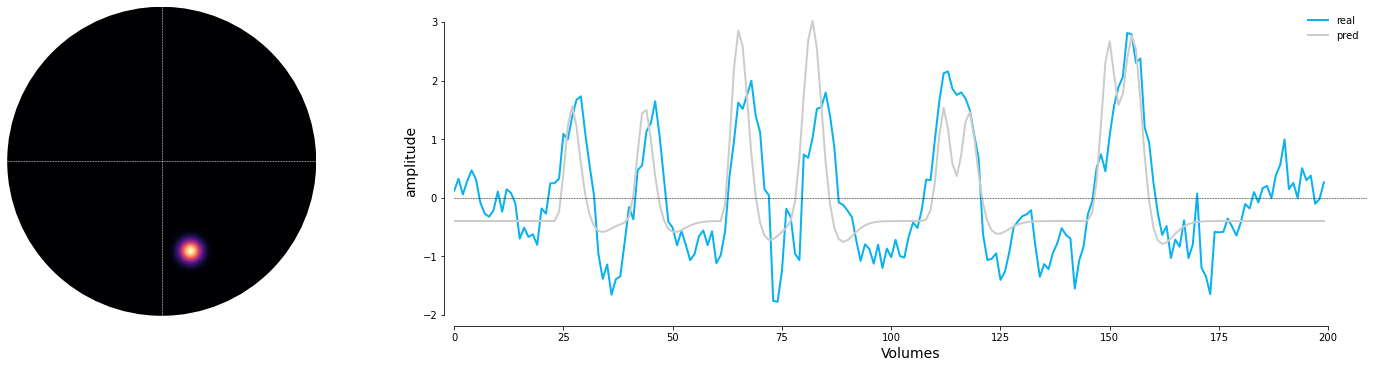

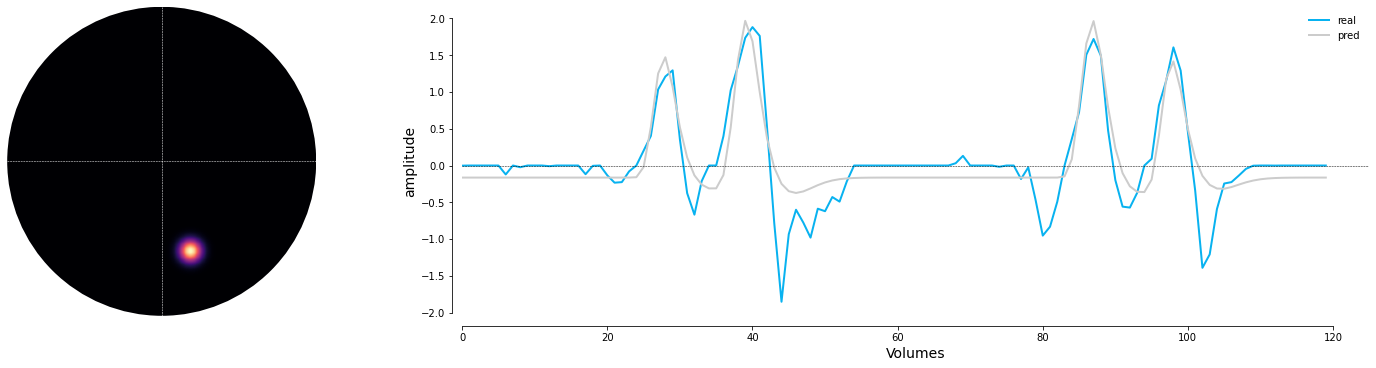

In [11]:
idc_similar_prfs = prf.find_most_similar_prf(params, modelling2.gauss_grid, r2_thresh=0.5)
idx_max_r2 = utils.find_max_val(modelling2.gauss_grid[idc_similar_prfs][:,-1])[0]

print(f"In partial FOV experiment, pRF vox = {vox}")
_,_,_ = modelling.plot_vox(vox_nr=vox, stage='grid')

print(f"In whole brain experiment, pRF vox = {idc_similar_prfs[idx_max_r2]}")
_,_,_ = modelling2.plot_vox(vox_nr=idc_similar_prfs[idx_max_r2], stage='grid')

This suggests that the two experiments elicit incongruent responses; we'd expect that if we're targeting vertex 1837 based on experiment 1, we retrieve those parameters in experiment 1. Rather, the pRF that was assigned to vertex 1387 is assigned to vertex 336 in experiment 2..

pRF location in partial FOV experiment


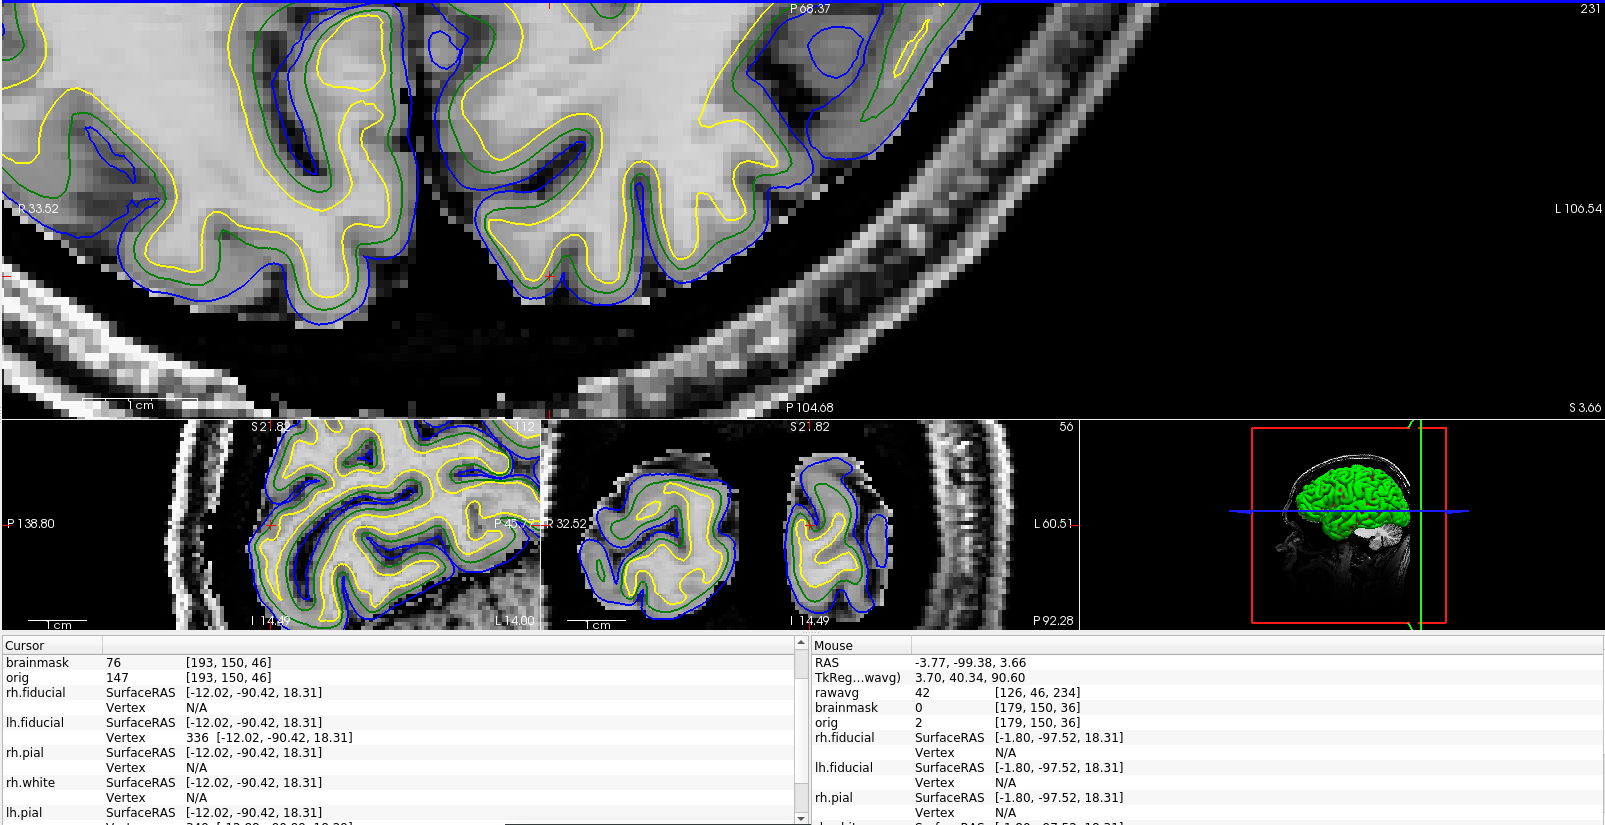

In [12]:
print("pRF location in partial FOV experiment")
Image(filename="../imgs/336.png")

pRF location in whole-brain experiment (session 1)


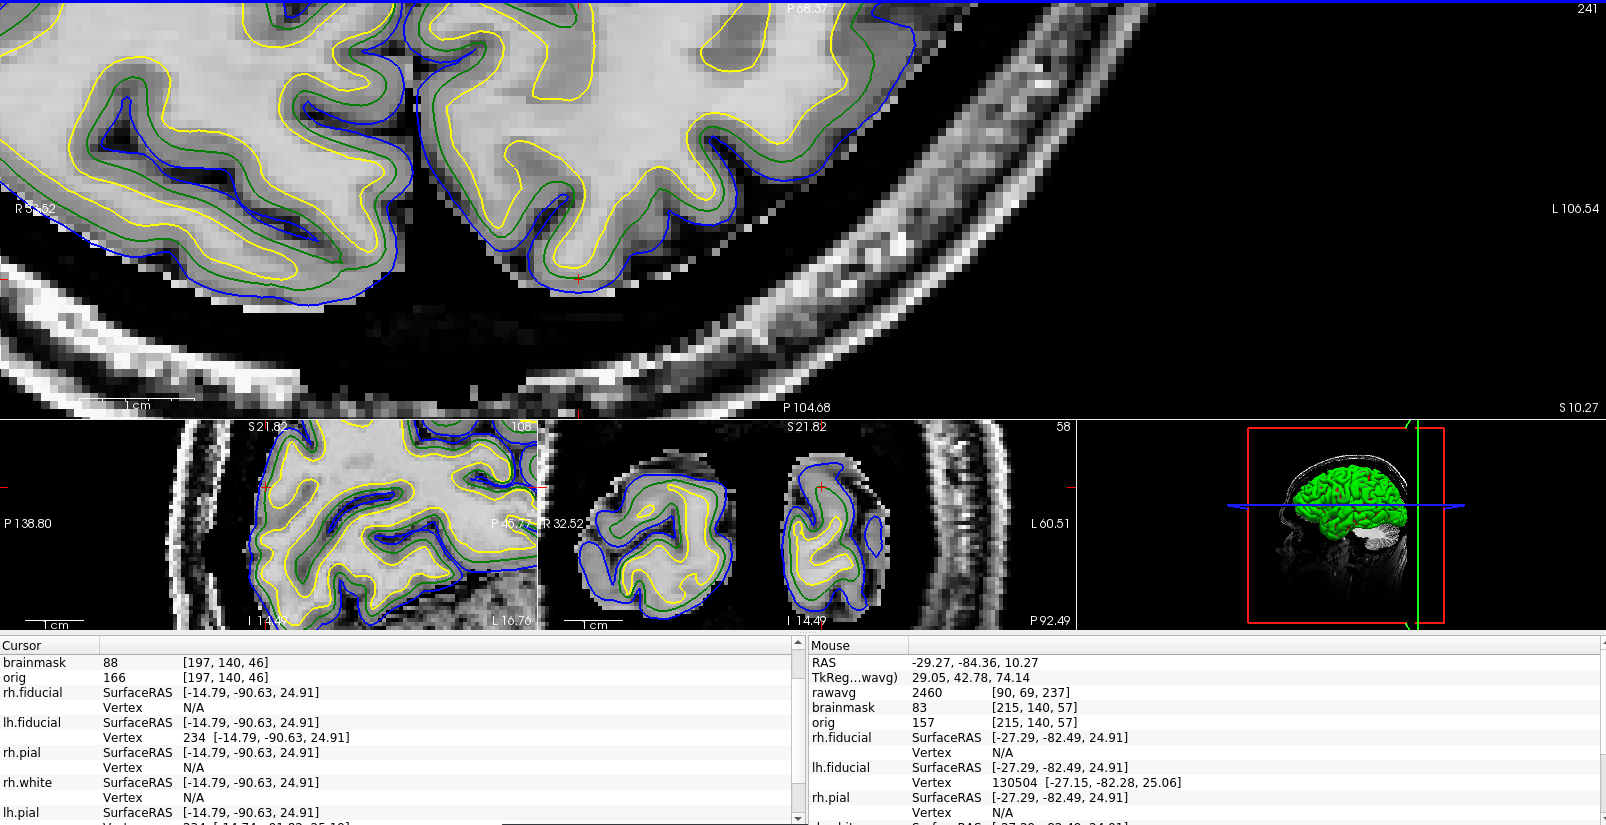

In [13]:
print("pRF location in whole-brain experiment (session 1)")
Image(filename="../imgs/234.png")

### Where is target vertex in partial FOV experiment

In [14]:
sub = utils.CollectSubject("sub-003", cx_dir=opj(base_dir, 'derivatives', 'pycortex', 'sub-003'))
vert = sub.return_target_vertex(hemi='lh')
pars = sub.return_prf_params(hemi='lh')
print(f"Target vertex in whole-brain experiment: {vert}")
print(f"With parameters: {pars}")

Target vertex in whole-brain experiment: 646
With parameters: [1.4106846055019346, -1.9416407864998737, 0.4388850415512466, 1.5524366972385906e-05, -0.2958866655826568, 0.7815219759941101]


In whole brain experiment, pRF vox = 646
In partial FOV experiment, pRF vox = 134221


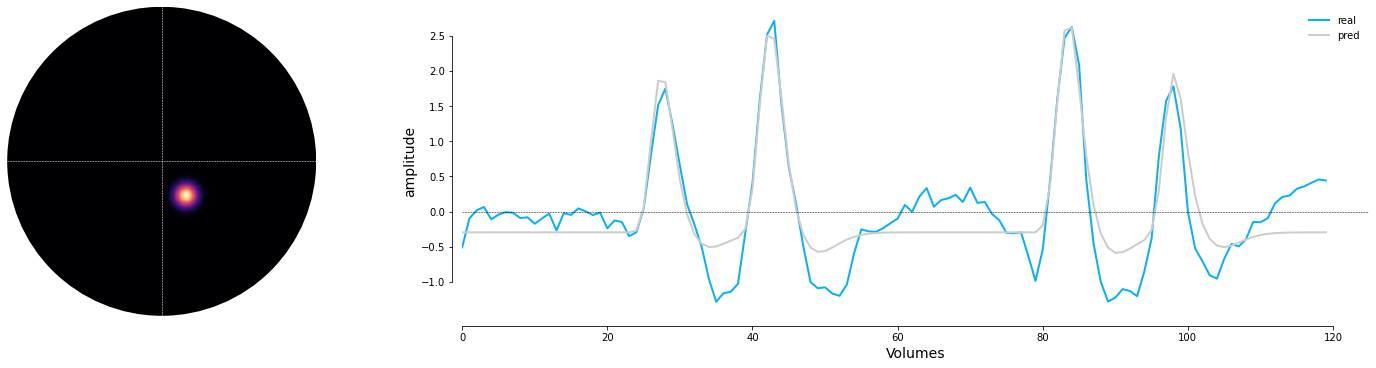

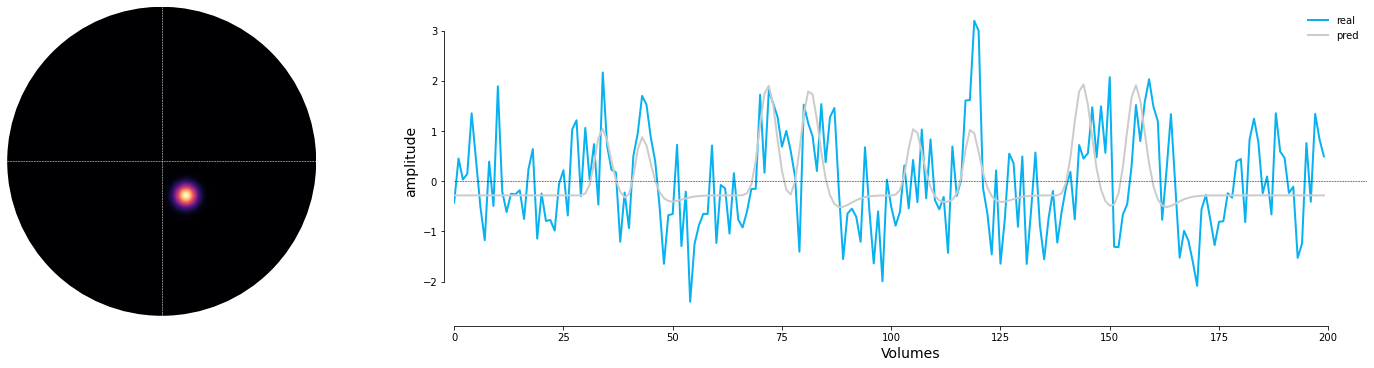

In [15]:
# plot whole-brain vertex
print(f"In whole brain experiment, pRF vox = {vert}")
target_pars,target_vert,target_tc = modelling2.plot_vox(vox_nr=vert, stage='grid')

# find similar pRFs in partial FOV experiment
idc_similar_prfs = prf.find_most_similar_prf(pars, modelling.gauss_grid, r2_thresh=0)

# find the one with the highest r2
idx_max_r2 = utils.find_max_val(modelling.gauss_grid[idc_similar_prfs][:,-1])[0]

# plot
print(f"In partial FOV experiment, pRF vox = {idc_similar_prfs[idx_max_r2]}")
tmp_pars,tmp_vert,tmp_tc = modelling.plot_vox(vox_nr=idc_similar_prfs[idx_max_r2], stage='grid')

target pRF location in whole-brain experiment (session 1)


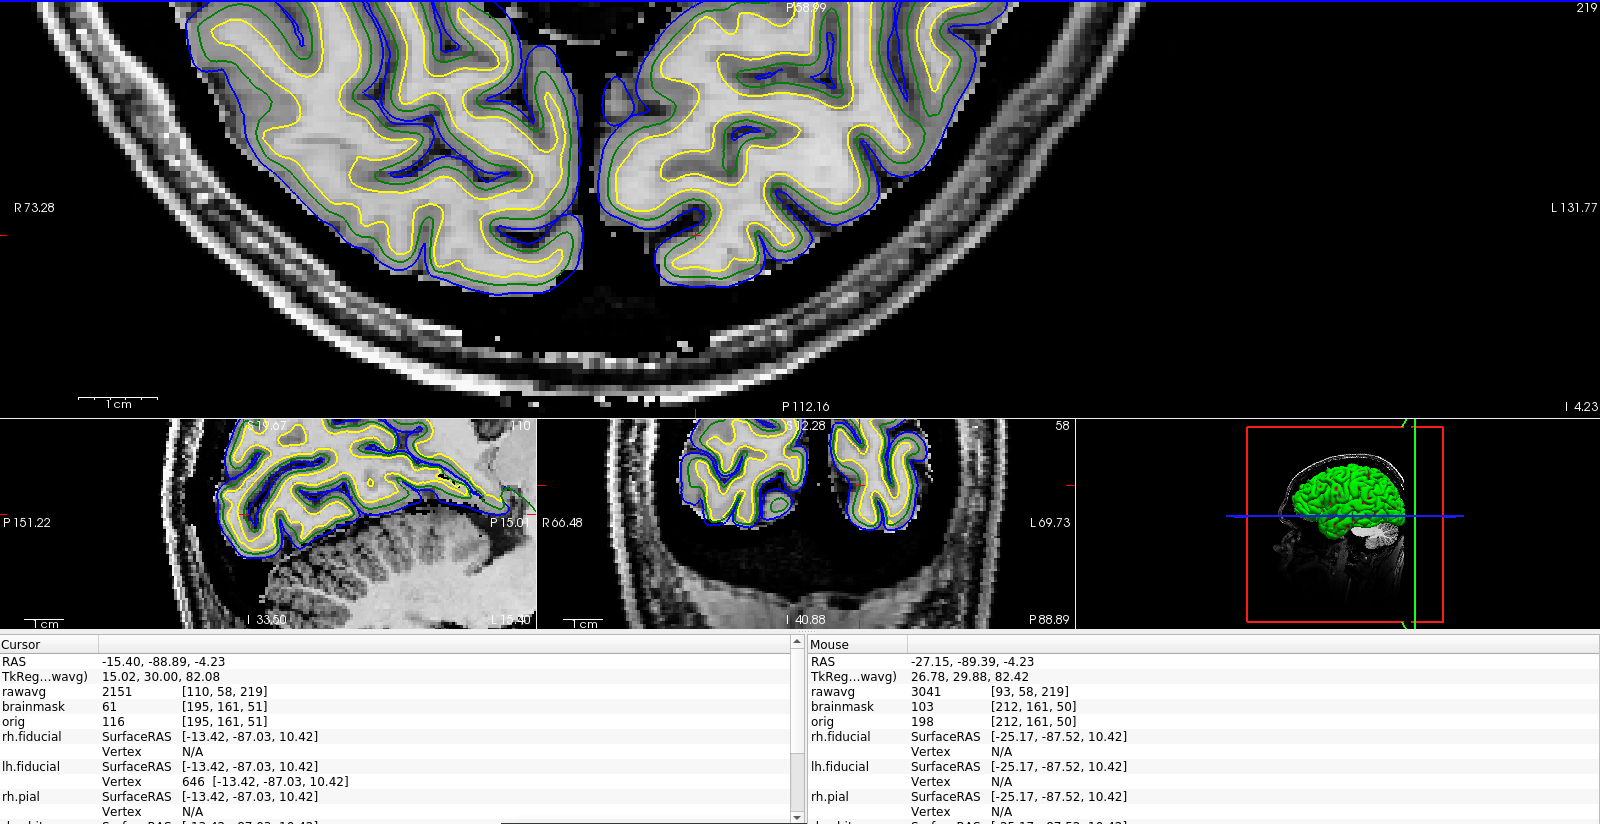

In [16]:
print("target pRF location in whole-brain experiment (session 1)")
Image(filename="../imgs/646.png")

similar pRF as target pRF in partial FOV experiment


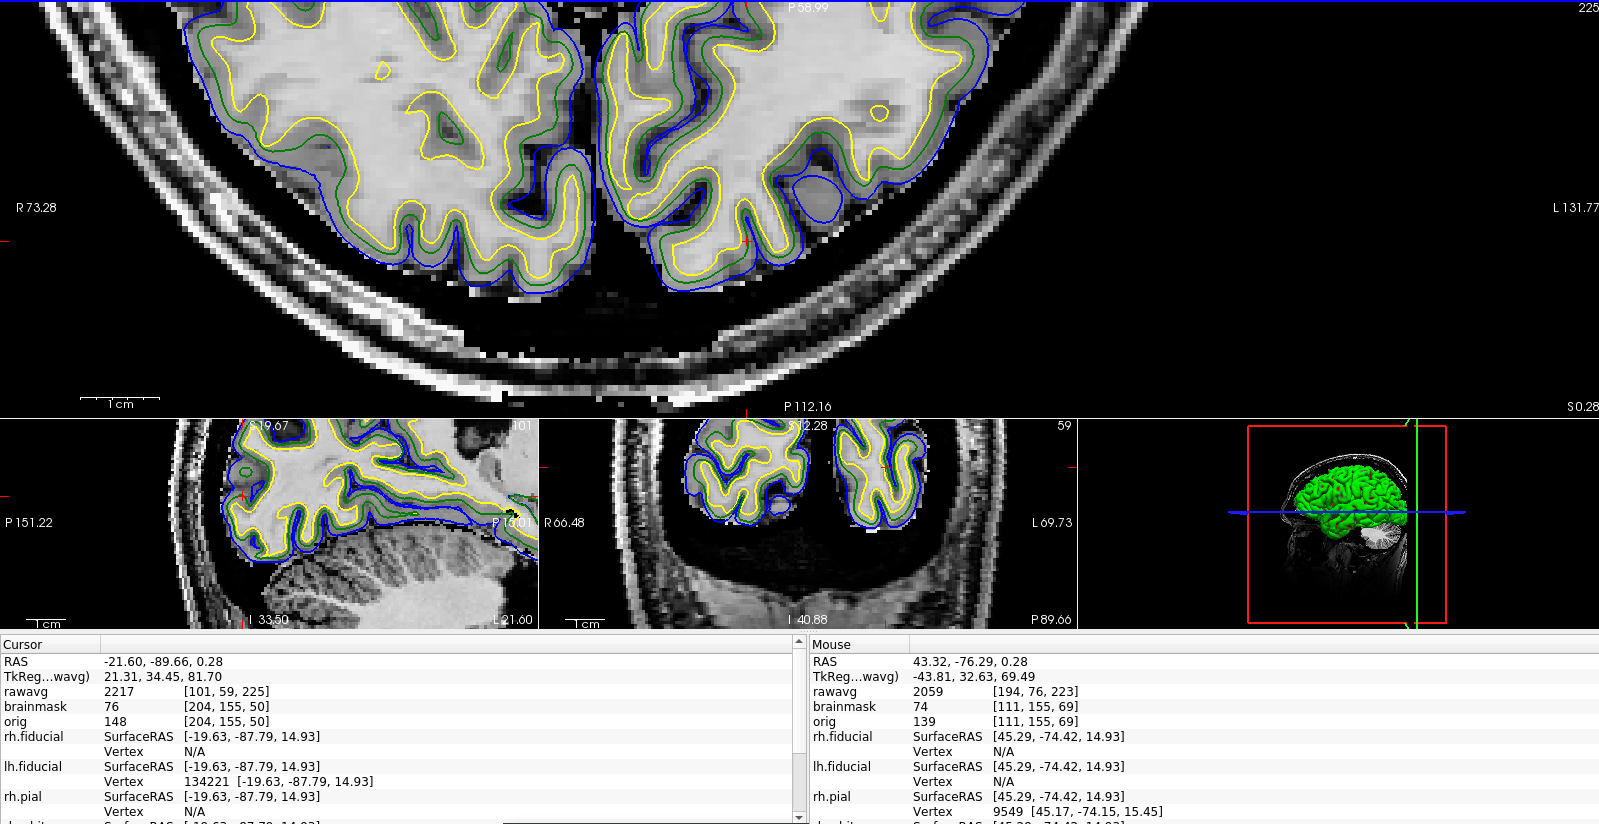

In [17]:
print("similar pRF as target pRF in partial FOV experiment")
Image(filename="../imgs/134221.png")

---
# Edit after https://github.com/spinoza-centre/pRFline/issues/1

This issue contains a summary of the meeting that took place on the 14th of Jan, 2022. Above I looked for the best-fitting vertex in the partial FOV (3D-EPI) acquisition and compared matches those parameters with the pRF-estimates obtained in the whole-brain acquisition. This yielded a different vertex. However, as mentioned in the issue, there's loads of vertices with that particular set of pRF-estimates, so it's not the most relevant test. What's more relevant is to get the whole-brain (session 1) estimates from our target vertex, run that through the design matrix of the 3D-EPI acquisition, and see how much variance it explains in the timecourse of the target vertex

In [18]:
print(f"Target vertex in whole-brain experiment: {vert}")
print(f"With parameters: {pars}")

Target vertex in whole-brain experiment: 646
With parameters: [1.4106846055019346, -1.9416407864998737, 0.4388850415512466, 1.5524366972385906e-05, -0.2958866655826568, 0.7815219759941101]


One problem with the current setup: the design matrix of session 1 has a shape of (250,250) while the 3D-EPI design matrix has shape (270,270). To multiply the convolved design matrix with the pRF we need equal axis sizes. We can do this using `scipy.ndimage.zoom` (see [this](https://stackoverflow.com/questions/47775621/interpolate-resize-3d-array) post on StackOverflow):

Design shape: 	 (270, 270, 200)
Old pRF shape: 	 (1, 250, 250)
New pRF shape: 	 (1, 270, 270)


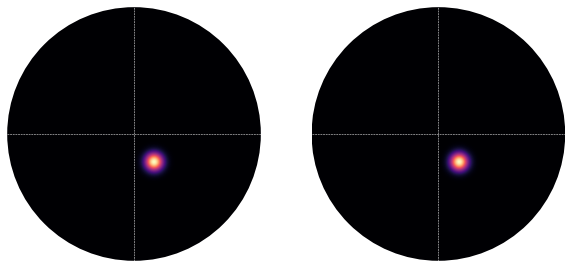

In [19]:
# convolved design matrix 3D-EPI acq:
dm = modelling.gaussian_model.stimulus.convolved_design_matrix
dx = modelling.gaussian_model.stimulus.dx

print(f"Design shape: \t {dm.shape}")

# transform shape 250 to 270 with scipy.zoom
increase_factor = (dm.shape[0]/target_vert.shape[-1])
new_array = zoom(target_vert, (1, increase_factor, increase_factor))

print(f"Old pRF shape: \t {target_vert.shape}")
print(f"New pRF shape: \t {new_array.shape}")

# plot for comparison
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(1,2)
axs = fig.add_subplot(gs[0,0])
prf.plot_prf(target_vert, vf_extent=[-5,5])

axs = fig.add_subplot(gs[0,1])
prf.plot_prf(new_array, vf_extent=[-5,5])

This is the pRF-fit + data from the target vertex in response to the design matrix of the 3D-EPI acquisition (this code is mainly here to get the variabel `pfov_tc`, which represents the fMRI-signal in our target vertex during the 3D-EPI acquisition)

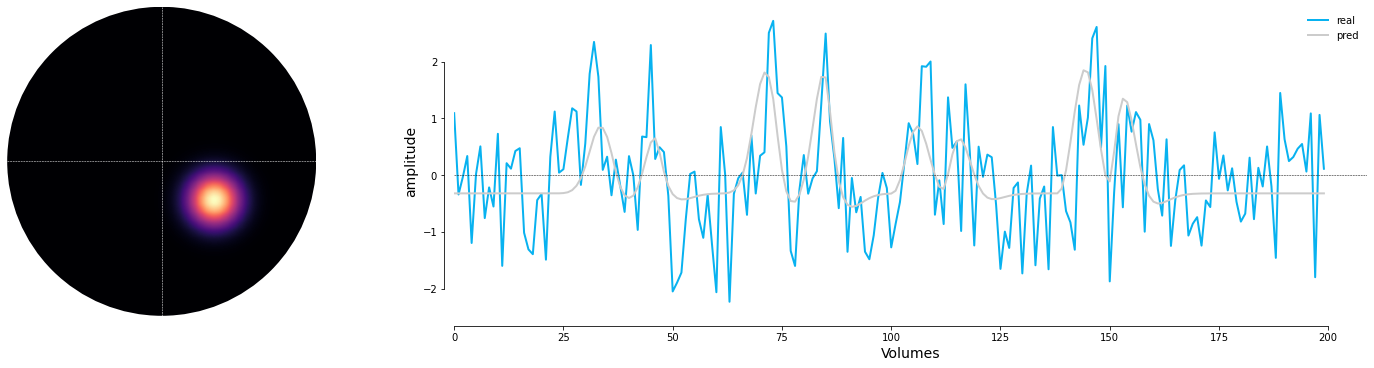

In [20]:
pfov_pars,pfov_prf,pfov_tc = modelling.plot_vox(vox_nr=vert, stage='grid')

We can plot the pRFs from the same target vertex (`646`) in both acquisitions, and estimate the displacement with `linescanning.prf.distance_centers`

distance between prfs = 1.64 dva


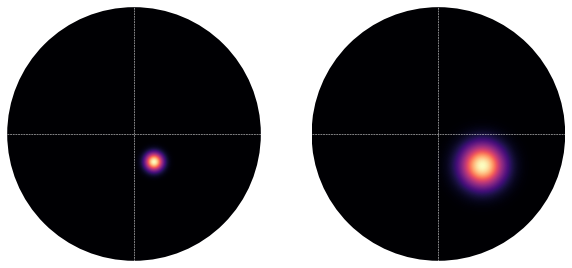

In [21]:
# plot for comparison
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(1,2)
axs = fig.add_subplot(gs[0,0])
prf.plot_prf(target_vert, vf_extent=[-5,5])

axs = fig.add_subplot(gs[0,1])
prf.plot_prf(pfov_prf, vf_extent=[-5,5])

dist = prf.distance_centers(target_pars, pfov_pars)
print(f"distance between prfs = {round(dist,2)} dva")

Now, let's see what happens if we insert the session 1 pRF parameters into the design matrix of the 3D-EPI acquisition (i.e., return the prediction by inserting the session 1 parameters into the model specification of the 3D-EPI fit)

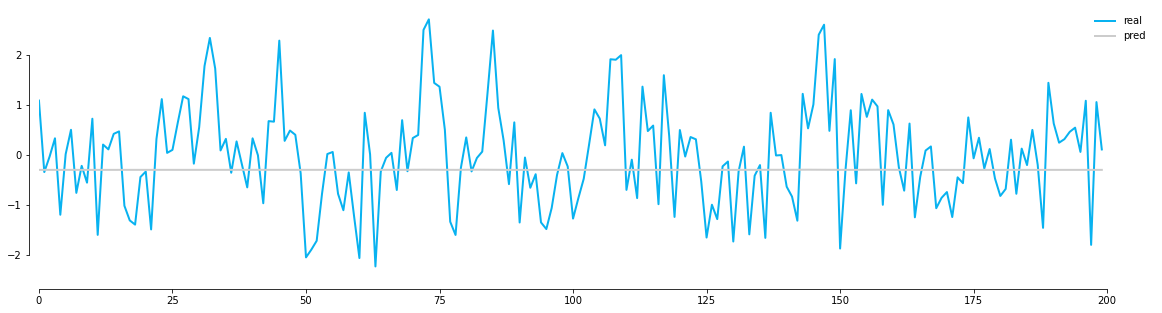

In [30]:
# run convolved design matrix through pRF
pfov_pred = modelling.gaussian_model.return_prediction(*pars[:-1]).T
utils.LazyPlot([pfov_tc, pfov_pred], set_xlim_zero=True, figsize=(20,5), color=['#08B2F0', '#cccccc'], labels=['real', 'pred'], line_width=2)

The prediction obtained by inserting `session 1` parameters in the design of `3D-EPI`-acquisition is pretty much a flat line. Let's plot the prediction timecourse only

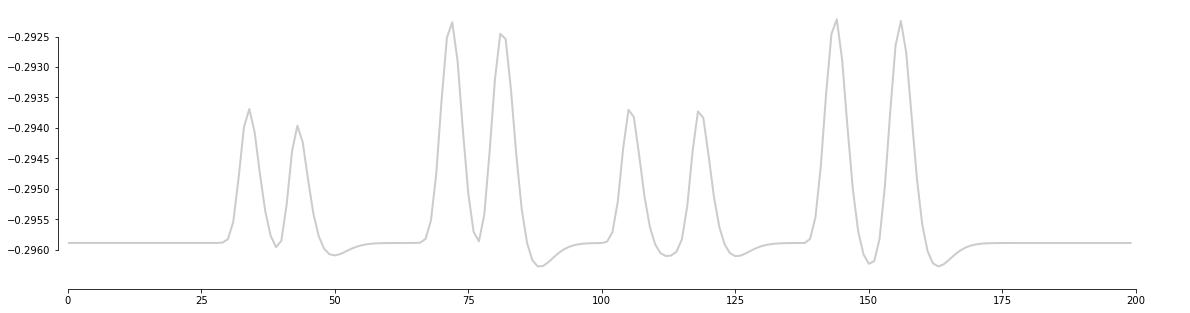

In [34]:
utils.LazyPlot(pfov_pred, set_xlim_zero=True, figsize=(20,5), color='#cccccc', line_width=2)

Very low values, so it seems that inserting the session 1 parameters in the 3D-EPI design does not explain a lot of variance in the timecourse. I know that by inserting `tmp_pars` (the best-matching pRF in the 3D-EPI acquisition) I do have somewhat of a curve. The only difference with `pars` (pRF-estimates from `session 1`) is the `beta` (3rd element):

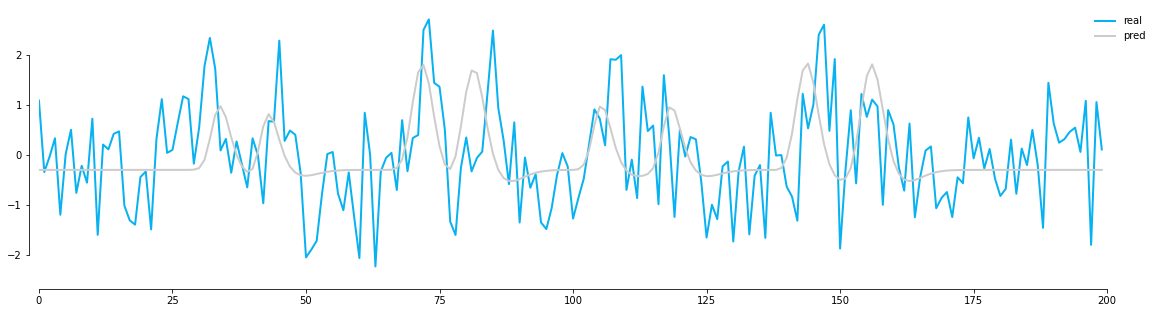

In [45]:
pars2 = np.array(pars.copy())
pars2[3] = 0.009

# run convolved design matrix through pRF
pfov_pred = modelling.gaussian_model.return_prediction(*pars2[:-1]).T
utils.LazyPlot([pfov_tc, pfov_pred], set_xlim_zero=True, figsize=(20,5), color=['#08B2F0', '#cccccc'], labels=['real', 'pred'], line_width=2)

Could this minor change be detected by a gaussian grid fit? Maybe more accurate to have iterative search parameters for both acquisitions? (Because the design matrix of session 1 for this subject was large 500x500, I downsampled that design matrix to 250x250 pixels. This iterative fit is still running.)